# Advanced Lane Finding Project

[--> Rubric Points](https://review.udacity.com/#!/rubrics/571/view) 

The Code is structured in four class:
* `Camera` handling image distortion correction and warping
* `ImageFilter` including different gradient filter
* `LaneDetector` including the lane search pipeline
* `LaneLine` representing a single lane line

All Classes can be found in the "lib" subdirectory.

In [278]:
import importlib
import cv2
import numpy as np
import lib
from matplotlib import gridspec
from lib.camera import Camera
from lib.image_filter import ImageFilter
from lib.lane_detector import LaneDetector
from lib.lane_line import LaneLine
import matplotlib.pyplot as plt
%matplotlib inline
importlib.reload(lib.camera)
importlib.reload(lib.image_filter)
importlib.reload(lib.lane_detector)
importlib.reload(lib.lane_line)
print("imported libs")

imported libs


## 1. Camera Calibration

I wrote a class named `Camera` that handles all relevant task regarding camera calibration, correction and warping. The code for the class `Camera` is contained in `lib/camera.py`.

In the calibration method `Camera.calibrate`, I start by preparing 9x6 "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function, which returns the following values:

| variable   | description |
|:----------:|:-----------:|
| `mtx`      |  3x3 floating-point camera matrix $A = \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix}$          |
| `imgpoints`|  image Points|
| `objpoints`|  object Points|
| `dist`     |  distortion coefficients ($k_1$, $k_2$, $p_1$, $p_2$, $k_3$)|
| `rvecs`    |  vector of rotation vectors |
| `tvecs`    |  vector of translation vectors|
| `ret`      |   root mean square (RMS) re-projection error ???|

Additional I wrote two methods to save and load calibration data. In order to load calibration data I use `Camera.load_calibration()`.
Applying this distortion correction to a test image (using the `cv2.undistort()` function), I obtain this result: 

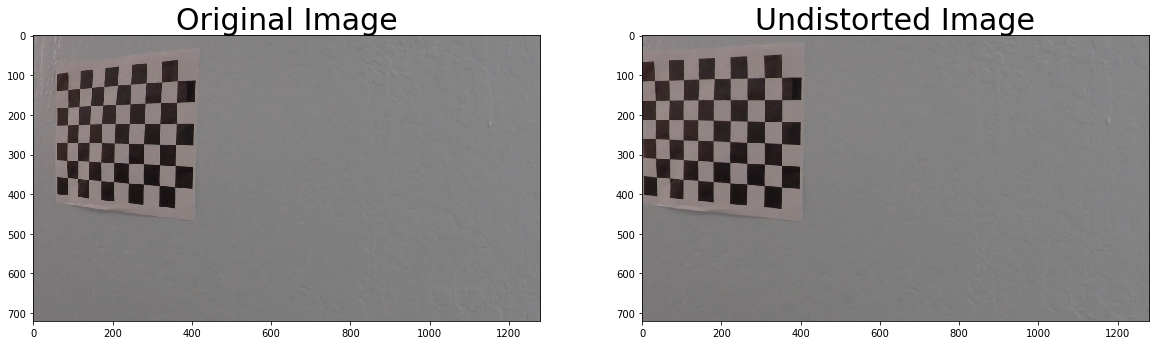

In [279]:
cam = Camera()
cam.load_calibration()

# Undistort image using camera matrix
img = cv2.imread('camera_cal/calibration19.jpg')
dst = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img), ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst), ax2.set_title('Undistorted Image', fontsize=30);

# 2. Pipeline (single images)

In the following sections I will explain the lane detection pipeline.

## Step 1: Camera correction

First the image is corrected using the existing `Camera`-class. This gives the following result:

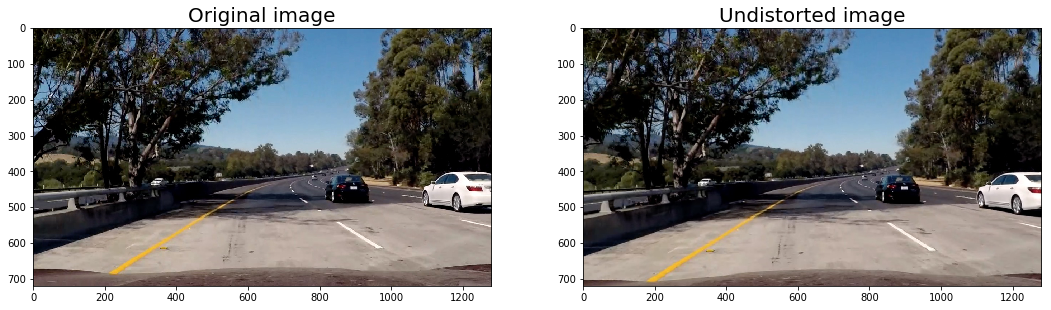

In [280]:
# Load and filter image
img = cv2.imread('test_images/color-shadow-example.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Instatiate camera, load calibration data and undistort
cam = Camera()
cam.load_calibration()
img_undist = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,9))
ax1.imshow(img), ax1.set_title('Original image', fontsize=20)
ax2.imshow(img_undist), ax2.set_title('Undistorted image', fontsize=20);
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Step 2: Gradient detection

After successfully correcting for camera distortions lane lines canidate pixels are marked using two methods:

First a threshold on gradient

1. After converting the image from RGB to HLS colorspace a threshold detection is used on the S-channel. I detect values between 170 and 255. This detects bringt pixels independent of the color.
2. A gradient detection is applied on the L-Channel of the converted image. I used a Sobel filter in x-direction and a threshold betwenn 20 and 100. The Sobel filter detect edges 

Results are shown in blue (S-channel threshold) and green (Sobel-X) respectively. It can be seen, that lane lines are detected even in presence of shadow and light.

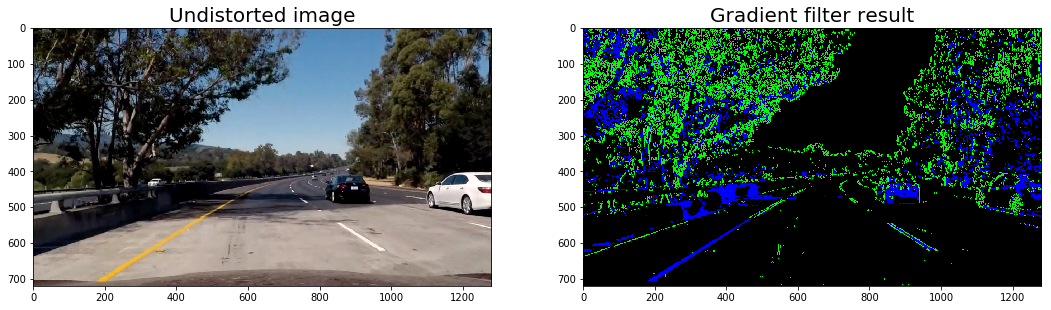

In [281]:
# Load and filter image
color_binary, result = ImageFilter.gradient_filter(img_undist, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
ax1.imshow(img_undist);  ax1.set_title('Undistorted image', fontsize=20)
ax2.imshow(color_binary); ax2.set_title('Gradient filter result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.show()

## Step 3: Perspective Trasformation

For the perpective transformation I used `cv2.warpPerspective`. In order to warp an image a transformation matrix is required. This matrix can be calculated using `cv2.getPerspectiveTransform` for given source and destination points. The code can be found in `Camera.warp_birdeye`.

As source points i marked for points in `straight_lines1.jpg`. On the right side I put a marker after a long dash, which allows me to relate the pixel measurement to a real world measurement of distance later. The source points end up beeing:

```
133         src = [[308,648],[1000,648],[579,460],[703,460]]
```

Based on my research I found that typical lane width in California, USA is 3.7m or 12ft. Also I found that "each dashed line measures 10 feet, and the empty spaces in-between measure 30 feet". This lead me to the definition of the real world distances between my marker source points:

```
129         Lane_W = factor*(12)          # ft (lande width)
130         Lane_D = factor*(30+10+30+10) # ft (lane distance)
```

The factor of 5 is used to transfer real world distances to pixels again. This gives me the new image coordinates of the warped image.

```
140         dst = np.float32([[offset_x,        img_size[1]+offset_y],
141                           [Lane_W+offset_x, img_size[1]+offset_y],
142                           [offset_x,        img_size[1]-Lane_D+offset_y],
143                           [Lane_W+offset_x, img_size[1]-Lane_D+offset_y]])
```

The offsets are defined as follows. An additional half lane width is used on the left and right side.

```
140             offset_x = int(Lane_W/2);
141             offset_y = -5;
142             cut_x    = 2*offset_x + Lane_W;
```

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image. To check for paralellity an additional yellow line is given. My approach is a little bit different from the approach showed in class, as it gives correct image proportions for the birdeye view. This is useful because pixel distances in the warped image can be converted to real world distanes using a factor of 5 px/ft.

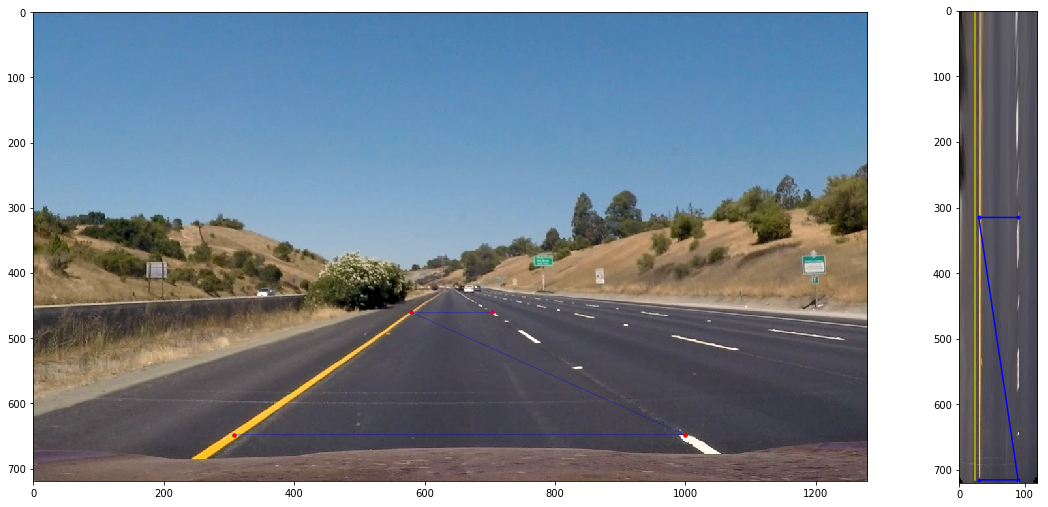

In [282]:
cam = Camera()
cam.load_calibration()

# Load image and warp
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_warp = cam.warp_birdeye(image)

fig = plt.figure(figsize=(18, 9)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[10.6, 1]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(image)
ax0.plot(cam.src[:,0],cam.src[:,1],'b.-', linewidth=0.3)
for i in range(4): ax0.plot(cam.src[i,0],cam.src[i,1],'r.')

ax1 = plt.subplot(gs[1])
ax1.imshow(image_warp[0:,:,:])
ax1.plot(cam.dst[:,0],cam.dst[:,1],'b.-')
ax1.plot([25,25],[0,715], 'y-')
plt.show()

## Step 4:  Lane detection and model fitting

The relevant method are `LandeDetector.find_window_centroids` and `LaneLine.fit_next`.

For the lane detection is used the approach described in the lecture using a convolution signal and finding the maximum in the convoluted signal with little modifications. I used a windows width of 5 and a window height of 80. 
Additionally I also include the y-positions of the detected lane segments in `window_centroids`.

For the fitting I tried different approaches to increase robustness. First I implemented a simple version of the [https://en.wikipedia.org/wiki/Random_sample_consensus RANSAC algorithm] but then decided to use a simple approach for outlier rejection. The method for outlier rejection can be found in `LaneLine.idx_reject_outliers`. First the data is normalized [http://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list using the median] and then compared to `m` of 2.0. Also lane segments very close to the left edge of the image are rejected.

As shown in the following image second order polynoms are fitted to the detected data:
![](http://localhost:8888/files/CarND-Advanced-Lane-Lines/output_images/color_fit_lines.jpg "Color Fit Lines")
Img. 1

In order to detect wrong detections over time the lane coordinates are predicted for a distance of [50, 150, 250, 350, 450, 550] px using the newly detected coeffients and using the coeffients from the previous detection. If the RMSE is bigger then 10 the detection of the currect frame is invalid.
In order to smooth the result over time the coeffients are filtered with an adaption rate of 0.05.

The result is shown in the following images:

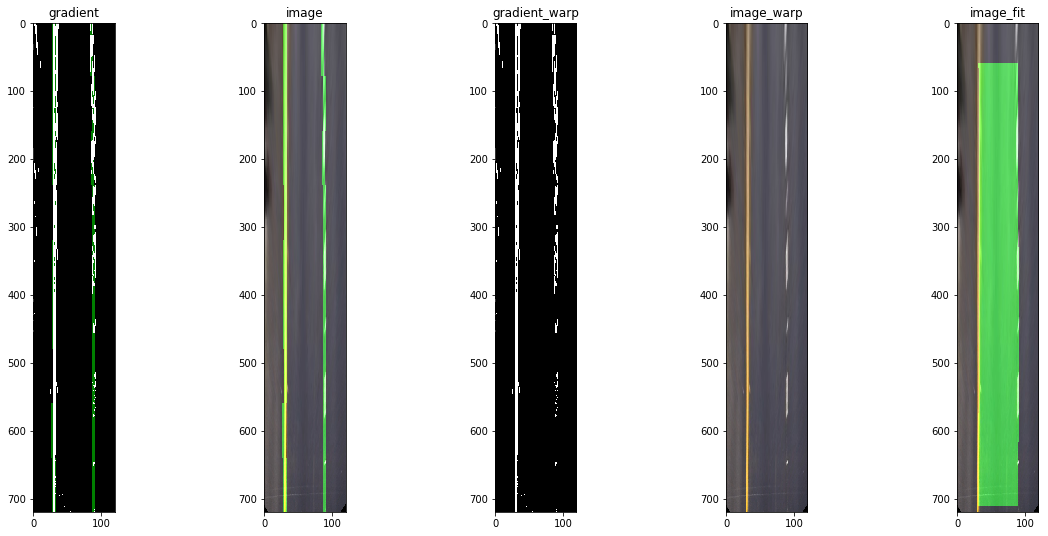

In [283]:
# Run full pipeline
ld = LaneDetector()
images = ld.pipeline(cam, ImageFilter, image)

# Display the final results
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 9))
ax1.imshow(images['gradient']);                  ax1.set_title('gradient')
ax2.imshow(images['image']);                     ax2.set_title('image')
ax3.imshow(images['gradient_warp'],cmap='gray'); ax3.set_title('gradient_warp')
ax4.imshow(images['image_warp']);                ax4.set_title('image_warp')
ax5.imshow(images['image_fit']);                 ax5.set_title('image_fit')
plt.show()    

## Step 5: Calulation radius of curvature and relative vehicle position

I implemented two methods. `LaneLine.get_radius` returns the radius of curvature of the lane.
`LaneLine.get_vehicle_offset` returns the position of the vehicle with respect to center.

```
factor     = 5 # px/ft
ft_to_m    = 0.3048 # m/ft
ym_per_pix = (1/factor) * ft_to_m # ft/px * m/ft => m/px
xm_per_pix = (1/factor) * ft_to_m # ft/px * m/ft => m/px
```

The curvature can be calculated from:

```
((1 + (2*self.fit_cr[0]*y_eval*ym_per_pix + self.fit_cr[1])**2)**1.5)/ np.absolute(2*self.fit_cr[0])
```

It is calculated for both lanes and then averaged.
The offset is calculated from

```
center_px = 59
lane_offset = (center_px - self.fit_cr[2])*xm_per_pix # TODO: Das ist feet
```

where center_px in the center of the car in the warped image. The value 59 was estimated based on an image where the car was driving in the center of the road and then calculating finding the mid between the two road lines. The lane offset is calculated for each lane. The vehicle offset is then calculated from the sum of both lane offsets.

## Final result

The full pipeline is given in `LaneDetector.pipeline`. It gives the following final result:
Blue dots mark the dected lane segments, while the green area is calculated from the fitted polynomial model.

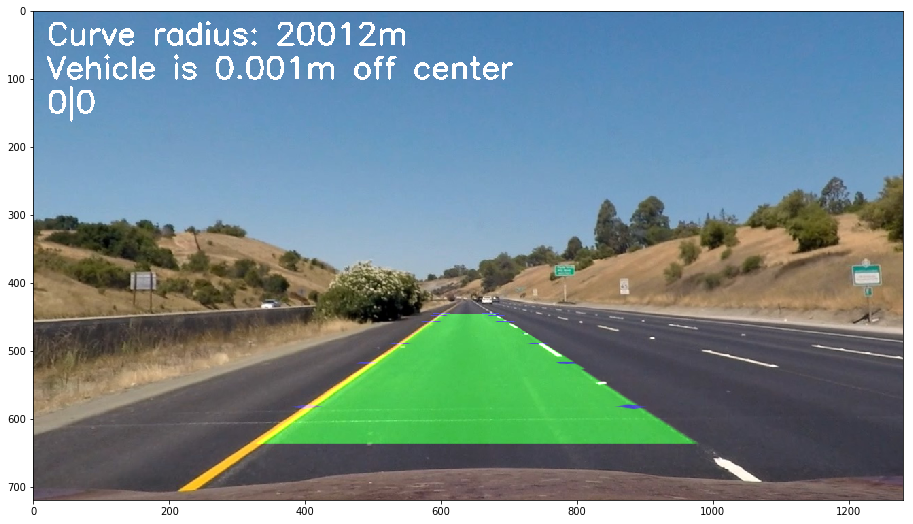

In [284]:
# Display the final results
plt.figure(figsize=(20, 9))
plt.imshow(images['final']);

# 3. Pipeline (video)

Final result on `project_video.mp4` looks like:

In [11]:
from IPython.display import HTML
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format('project_video_lane_detection.mp4'))

Alternative: [link to video result](./project_video_lane_detection.mp4)

# 4. Discussion


Currently both lanes a detected independently. Since the road width mostly stays constant, this informations can be used. An idea would be to calculate the confidence for both lane lines and if one confidence is low the second lane is estimated from the lane with high confidence.